# DonorsChoose

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

!pip install chart_studio
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [ ]:
project_data = pd.read_csv('/content/drive/My Drive/Donors choose/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/Donors choose/resources.csv')

In [ ]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [ ]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [ ]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [ ]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
print(price_data.shape)
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

(260115, 3)


## 1.2 preprocessing of `project_subject_categories`

In [ ]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [ ]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [ ]:
project_data=project_data.dropna(subset=['teacher_prefix'])

## 1.3 Text preprocessing

In [ ]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [ ]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,essay
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,I have been fortunate enough to use the Fairy ...
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,213.03,8,SpecialNeeds,SpecialNeeds,Imagine being 8-9 years old. You're in your th...


In [ ]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109245/109245 [01:05<00:00, 1656.03it/s]


In [ ]:
# after preprocesing
project_data['clean_essay']=preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
project_data.drop(['essay'], axis=1, inplace=True)


<h2><font color='black'> 1.4 Preprocessing of `project_title`</font></h2>

In [ ]:
# similarly you can preprocess the titles also

preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:02<00:00, 40608.37it/s]


In [ ]:
project_data['clean_title']=preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)


## 1.5 Preparing data for models

In [ ]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_essay', 'clean_title'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [ ]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,clean_essay,clean_title
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,My students need STEM kits to learn critical s...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom


In [ ]:
"""a=project_data[project_data['project_is_approved']==1]
a=a.sample(n=16000)

b=project_data[project_data['project_is_approved']==0]
b=b.sample(n=16000) 

temp=pd.concat([a,b])

temp = temp.sample(frac=1).reset_index(drop=True)

print(temp.shape)
print(temp['project_is_approved'].value_counts())"""

"a=project_data[project_data['project_is_approved']==1]\na=a.sample(n=16000)\n\nb=project_data[project_data['project_is_approved']==0]\nb=b.sample(n=16000) \n\ntemp=pd.concat([a,b])\n\ntemp = temp.sample(frac=1).reset_index(drop=True)\n\nprint(temp.shape)\nprint(temp['project_is_approved'].value_counts())"

In [ ]:
project_data=project_data.sample(frac=0.4)
project_data['project_is_approved'].value_counts()

1    37173
0     6525
Name: project_is_approved, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(27966, 15)
(6992, 15)
(8740, 15)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape {0}'.format(Counter(y_train)))

X_train = pd.DataFrame(X_train,columns = X.columns)
X_train.head(5)

Resampled dataset shape Counter({1: 23790, 0: 23790})


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity,clean_categories,clean_subcategories,clean_essay,clean_title
0,25691,p189907,cd8df223587cae4dbb351d09d56388f6,Mrs.,MA,2017-03-05 20:19:18,Grades PreK-2,My students need Headphones to assist reading ...,1,3.49,30,Literacy_Language,Literacy,teacher low income high poverty school distric...,helping enhance technology
1,149163,p150538,ea4d243288961536dee5c436e661fb9f,Ms.,NJ,2017-02-01 19:38:33,Grades 3-5,My students need a classroom library that will...,0,673.69,6,Literacy_Language,Literacy,fifth grade students live low income area sout...,classroom library
2,10889,p234451,3e4a20fda738afb52e7c5d8b5e7599cc,Mrs.,CA,2016-09-02 02:49:03,Grades 3-5,My students need 10 heart rate monitor pulse b...,1,56.79,12,Health_Sports,Gym_Fitness,quality physical education program offered stu...,heron flyers commit to be fit
3,170509,p096919,132f4c4b5a94ef5e1158a69a61c66602,Ms.,WI,2016-08-03 15:23:03,Grades 3-5,"My students need new yoga dvd's, different sea...",62,609.24,29,Health_Sports,Health_Wellness,blessed 10 super special education students wo...,stretch balance bike day away
4,8674,p230264,ab8c90950cb226f59af432954faa727e,Mrs.,NY,2016-08-17 22:37:36,Grades PreK-2,My students need basic art and school supplies...,2,400.35,30,SpecialNeeds Music_Arts,SpecialNeeds VisualArts,title school near beach new york community stu...,creative writing visual arts the sea


In [ ]:
print(X_train.shape)

(47580, 15)


### 2 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [ ]:
#Categories

from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer1.fit(X_train['clean_categories'].values)

X_train_cat_ohe = categories_one_hot.transform(X_train['clean_categories'])
X_cv_cat_ohe = categories_one_hot.transform(X_cv['clean_categories'])
X_test_cat_ohe = categories_one_hot.transform(X_test['clean_categories'])

print(vectorizer1.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_cat_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_cat_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_cat_ohe.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of train matrix after one hot encodig  (47580, 9)
Shape of cv matrix after one hot encodig  (6992, 9)
Shape of test matrix after one hot encodig  (8740, 9)


In [ ]:
#Subcategories

vectorizer2 = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer2.fit(X_train['clean_subcategories'].values)


X_train_subcat_ohe = sub_categories_one_hot.transform(X_train['clean_subcategories'])
X_cv_subcat_ohe = sub_categories_one_hot.transform(X_cv['clean_subcategories'])
X_test_subcat_ohe = sub_categories_one_hot.transform(X_test['clean_subcategories'])

print(vectorizer2.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_subcat_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_subcat_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_subcat_ohe.shape)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of train matrix after one hot encodig  (47580, 30)
Shape of cv matrix after one hot encodig  (6992, 30)
Shape of test matrix after one hot encodig  (8740, 30)


In [ ]:
#School state
vectorizer = CountVectorizer( lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'])
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'])
X_test_state_ohe = vectorizer.transform(X_test['school_state'])

print(vectorizer.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_state_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_state_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_state_ohe.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encodig  (47580, 51)
Shape of cv matrix after one hot encodig  (6992, 51)
Shape of test matrix after one hot encodig  (8740, 51)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values)


X_train_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'])
X_cv_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'])
X_test_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'])

print(vectorizer.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_prefix_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_prefix_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_prefix_ohe.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of train matrix after one hot encodig  (47580, 5)
Shape of cv matrix after one hot encodig  (6992, 5)
Shape of test matrix after one hot encodig  (8740, 5)


In [ ]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)

X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'])
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'])
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'])

print(vectorizer.get_feature_names())
print("Shape of train matrix after one hot encodig ",X_train_grade_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_grade_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_grade_ohe.shape)

['12', 'Grades', 'PreK']
Shape of train matrix after one hot encodig  (47580, 3)
Shape of cv matrix after one hot encodig  (6992, 3)
Shape of test matrix after one hot encodig  (8740, 3)


## 3 Vectorizing Text data

### 3.1 Bag of words

### 3.1.1 Essays

In [ ]:
print(X_train['clean_essay'].values[0])

teacher low income high poverty school district students faced not resources come school prepared learn students need headphones hear computers technology time headphones vital learning growth first grade classroom technology based world time many students unable afford additional supplies bring school help supporting amazing children would wonderful students need headphones order hear programs use daily ipads students required complete 60 minutes reading assistance ipad however many unable buy headphones hear program tried many affordable options earbuds break would appreciate help extremely essential tool utilize classroom thank taking time invest future little minds little goes long way thank bottom hearts appreciated guarantee item donated carefully taken care used diligently nannan


In [ ]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['clean_essay'])


X_train_essay_bow = vectorizer.transform(X_train['clean_essay'])
X_cv_essay_bow = vectorizer.transform(X_cv['clean_essay'])
X_test_essay_bow = vectorizer.transform(X_test['clean_essay'])


print("Shape of train matrix after one hot encodig ",X_train_essay_bow.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_essay_bow.shape)
print("Shape of test matrix after one hot encodig ",X_test_essay_bow.shape)

Shape of train matrix after one hot encodig  (47580, 12067)
Shape of cv matrix after one hot encodig  (6992, 12067)
Shape of test matrix after one hot encodig  (8740, 12067)


### 3.1.2 Titles 

In [ ]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit(X_train['clean_title'])


X_train_title_bow = vectorizer.transform(X_train['clean_title'])
X_cv_title_bow = vectorizer.transform(X_cv['clean_title'])
X_test_title_bow = vectorizer.transform(X_test['clean_title'])


print("Shape of train matrix after one hot encodig ",X_train_title_bow.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_title_bow.shape)
print("Shape of test matrix after one hot encodig ",X_test_title_bow.shape)

Shape of train matrix after one hot encodig  (47580, 2136)
Shape of cv matrix after one hot encodig  (6992, 2136)
Shape of test matrix after one hot encodig  (8740, 2136)


### 3.2 TFIDF vectorizer

### 3.2.1 Essay

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['clean_essay'])

X_train_essay_tfidf = vectorizer.transform(X_train['clean_essay'])
X_cv_essay_tfidf = vectorizer.transform(X_cv['clean_essay'])
X_test_essay_tfidf = vectorizer.transform(X_test['clean_essay'])


print("Shape of train matrix after one hot encodig ",X_train_essay_tfidf.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_essay_tfidf.shape)
print("Shape of test matrix after one hot encodig ",X_test_essay_tfidf.shape)


Shape of train matrix after one hot encodig  (47580, 12067)
Shape of cv matrix after one hot encodig  (6992, 12067)
Shape of test matrix after one hot encodig  (8740, 12067)


### 3.2.2 Title

In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['clean_title'])

X_train_title_tfidf = vectorizer.transform(X_train['clean_title'])
X_cv_title_tfidf = vectorizer.transform(X_cv['clean_title'])
X_test_title_tfidf = vectorizer.transform(X_test['clean_title'])


print("Shape of train matrix after one hot encodig ",X_train_title_tfidf.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_title_tfidf.shape)
print("Shape of test matrix after one hot encodig ",X_test_title_tfidf.shape)

Shape of train matrix after one hot encodig  (47580, 2136)
Shape of cv matrix after one hot encodig  (6992, 2136)
Shape of test matrix after one hot encodig  (8740, 2136)


### 3.3 Using Pretrained Models: Avg W2V

In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/drive/My Drive/Donors choose/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
X_train_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_w2v_essay.append(vector)

print(len(X_train_w2v_essay))
print(len(X_train_w2v_essay[0]))

100%|██████████| 47580/47580 [00:14<00:00, 3357.83it/s]

47580
300


In [ ]:
X_train_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_w2v_title.append(vector)

print(len(X_train_w2v_title))
print(len(X_train_w2v_title[0]))

100%|██████████| 47580/47580 [00:00<00:00, 59901.60it/s]

47580
300


In [ ]:
# average Word2Vec
# compute average word2vec for each review.
X_cv_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_w2v_essay.append(vector)

print(len(X_cv_w2v_essay))
print(len(X_cv_w2v_essay[0]))

100%|██████████| 6992/6992 [00:02<00:00, 3304.32it/s]

6992
300


In [ ]:
# average Word2Vec
# compute average word2vec for each review.
X_test_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_w2v_essay.append(vector)

print(len(X_test_w2v_essay))
print(len(X_test_w2v_essay[0]))

100%|██████████| 8740/8740 [00:02<00:00, 3387.95it/s]

8740
300


In [ ]:
X_cv_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_cv_w2v_title.append(vector)

print(len(X_cv_w2v_title))
print(len(X_cv_w2v_title[0]))

100%|██████████| 6992/6992 [00:00<00:00, 53352.08it/s]

6992
300


In [ ]:
X_test_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_w2v_title.append(vector)

print(len(X_test_w2v_title))
print(len(X_test_w2v_title[0]))

100%|██████████| 8740/8740 [00:00<00:00, 57871.83it/s]

8740
300


### 3.4 Using Pretrained Models: TFIDF weighted W2V

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
X_train_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_essay.append(vector)




X_train_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_title.append(vector)

print(len(X_train_tfidf_w2v_essay))
print(len(X_train_tfidf_w2v_essay[0]))
print("="*50)
print(len(X_train_tfidf_w2v_title))
print(len(X_train_tfidf_w2v_title[0]))

100%|██████████| 47580/47580 [00:02<00:00, 23232.57it/s]

47580
300
47580
300


In [ ]:
X_cv_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_tfidf_w2v_essay.append(vector)


X_cv_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_tfidf_w2v_title.append(vector)

print(len(X_cv_tfidf_w2v_title))
print(len(X_cv_tfidf_w2v_title[0]))
print("="*30)
print(len(X_cv_tfidf_w2v_essay))
print(len(X_cv_tfidf_w2v_essay[0]))




100%|██████████| 6992/6992 [00:00<00:00, 19655.58it/s]

6992
300
6992
300


In [ ]:
X_test_tfidf_w2v_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_essay.append(vector)


X_test_tfidf_w2v_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_title.append(vector)

print(len(X_test_tfidf_w2v_title))
print(len(X_test_tfidf_w2v_title[0]))
print("="*30)
print(len(X_test_tfidf_w2v_essay))
print(len(X_test_tfidf_w2v_essay[0]))




100%|██████████| 8740/8740 [00:00<00:00, 19230.97it/s]

8740
300
8740
300


### 1.5.3 Vectorizing Numerical features

In [ ]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'clean_categories', 'clean_subcategories', 'clean_essay',
       'clean_title'],
      dtype='object')

In [ ]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_cv_price_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
X_test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 321.6501467002943, Standard deviation : 365.18798856470795


In [ ]:
proj_scalar = StandardScaler()
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_proj_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_cv_proj_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
X_test_proj_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 9.448024379991594, Standard deviation : 24.226677731780313


In [ ]:
len(X_train_price_standardized)

47580

### 1.5.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_bow = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_essay_bow,  X_train_title_bow))
X_cv_bow = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_essay_bow,  X_cv_title_bow))
X_test_bow = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_essay_bow,  X_test_title_bow))

print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)

(47580, 14303)
(6992, 14303)
(8740, 14303)


In [ ]:
X_train_tfidf = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_essay_tfidf,  X_train_title_tfidf))
X_cv_tfidf = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_essay_tfidf,  X_cv_title_tfidf))
X_test_tfidf = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_essay_tfidf,  X_test_title_tfidf))

print(X_train_tfidf.shape)
print(X_cv_tfidf.shape)
print(X_test_tfidf.shape)

(47580, 14303)
(6992, 14303)
(8740, 14303)


In [ ]:
X_train_w2v = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_w2v_essay,X_train_w2v_title))
X_cv_w2v = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_w2v_essay,  X_cv_w2v_title))
X_test_w2v = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_w2v_essay, X_test_w2v_title))

print(X_train_w2v.shape)
print(X_cv_w2v.shape)
print(X_test_w2v.shape)

(47580, 700)
(6992, 700)
(8740, 700)


In [ ]:
X_train_tfw2v = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_tfidf_w2v_essay,  X_train_tfidf_w2v_title))
X_cv_tfw2v = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_tfidf_w2v_essay,  X_cv_tfidf_w2v_title))
X_test_tfw2v = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_tfidf_w2v_essay,  X_test_tfidf_w2v_title))

print(X_train_tfw2v.shape)
print(X_cv_tfw2v.shape)
print(X_test_tfw2v.shape)

(47580, 700)
(6992, 700)
(8740, 700)


## Word to vector LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [ ]:
c=[0.001,0.001,0.005, 0.01, 0.05, 0.1, 1, 5, 10 ,50 ,100 ]
train_auc={}
cv_auc={}

for i in tqdm(c):
  lr = LogisticRegression(penalty='l2', C=i, solver='liblinear', class_weight='balanced')
  lr.fit(X_train_w2v, y_train)
  #predictiong train and cv then storing their accuracies

  train_w2v_pred=lr.predict_proba(X_train_w2v)
  a1= roc_auc_score(y_train, train_w2v_pred[:,1])
  train_auc[i]=a1

  cv_w2v_pred=lr.predict_proba(X_cv_w2v)
  a2= roc_auc_score(y_cv, cv_w2v_pred[:,1])
  cv_auc[i]=a2

print(train_auc)
print(cv_auc)



100%|██████████| 11/11 [06:33<00:00, 35.73s/it]

{0.001: 0.6660776734778759, 0.005: 0.6983416881035388, 0.01: 0.710100160063156, 0.05: 0.7321793961843163, 0.1: 0.7393172393796709, 1: 0.751423477213484, 5: 0.7528164065529952, 10: 0.752919665752651, 50: 0.7529538127948399, 100: 0.7529468759590934}
{0.001: 0.6636154784634134, 0.005: 0.6865158963893977, 0.01: 0.6926815607551525, 0.05: 0.70063555282435, 0.1: 0.7019462416292415, 1: 0.7003394038242031, 5: 0.698291321723133, 10: 0.6978209295374729, 50: 0.6974109266259046, 100: 0.6973540801892262}


In [ ]:
best_c= list(cv_auc.keys())[list(cv_auc.values()).index(max(list(cv_auc.values())))]
print(best_c)

0.1


In [ ]:
x= np.linspace(0,1)

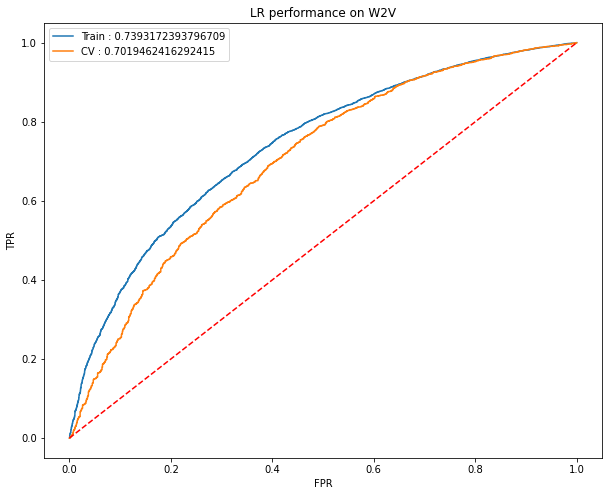

In [ ]:
lr= LogisticRegression(penalty='l2', solver= 'liblinear', class_weight='balanced', C=best_c)

lr.fit(X_train_w2v, y_train)

train_pred_prob=lr.predict_proba(X_train_w2v)
cv_pred_prob= lr.predict_proba(X_cv_w2v)

fpr1 , tpr1, thresholds1= roc_curve(y_train, train_pred_prob[:,1])
fpr2 , tpr2, thresholds2= roc_curve(y_cv, cv_pred_prob[:,1])


plt.figure(figsize=(10,8))
plt.plot(fpr1, tpr1, label="Train : "+str(roc_auc_score(y_train, train_pred_prob[:,1])))
plt.plot(fpr2, tpr2, label="CV : "+ str(roc_auc_score(y_cv, cv_pred_prob[:,1])))
plt.plot(x,x, 'r-', linestyle="--")
plt.title("LR performance on W2V")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()


## TFIDF W2V

In [ ]:
c=[0.001,0.001,0.005, 0.01, 0.05, 0.1, 1, 5, 10 ,50 ,100 ]
train_auc={}
cv_auc={}

for i in tqdm(c):
  lr = LogisticRegression(penalty='l2', C=i, solver='liblinear', class_weight='balanced')
  lr.fit(X_train_tfw2v, y_train)
  #predictiong train and cv then storing their accuracies

  train_tfw2v_pred=lr.predict_proba(X_train_tfw2v)
  a1= roc_auc_score(y_train, train_tfw2v_pred[:,1])
  train_auc[i]=a1

  cv_tfw2v_pred=lr.predict_proba(X_cv_tfw2v)
  a2= roc_auc_score(y_cv, cv_tfw2v_pred[:,1])
  cv_auc[i]=a2

print(train_auc)
print(cv_auc)



100%|██████████| 11/11 [05:28<00:00, 29.85s/it]

{0.001: 0.6898329911738219, 0.005: 0.7176520736915999, 0.01: 0.7261264627915446, 0.05: 0.7396804708991258, 0.1: 0.7432312862246916, 1: 0.7473278958859757, 5: 0.7475339654935711, 10: 0.7475276081998841, 50: 0.7475258943102575, 100: 0.7475247811654484}
{0.001: 0.6936463397980455, 0.005: 0.7073614686156137, 0.01: 0.7086394666934633, 0.05: 0.7057895760705166, 0.1: 0.7033730388784537, 1: 0.6962068450195436, 5: 0.6941470071397836, 10: 0.6937962662358577, 50: 0.6934786991731661, 100: 0.6934545434635293}


In [ ]:
best_c= list(cv_auc.keys())[list(cv_auc.values()).index(max(list(cv_auc.values())))]
print(best_c)

0.01


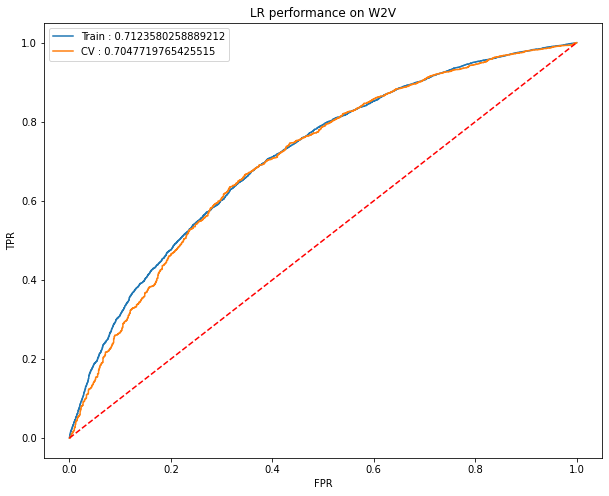

In [ ]:
lr= LogisticRegression(penalty='l2', solver= 'liblinear', class_weight='balanced', C=best_c)

lr.fit(X_train_tfw2v, y_train)

train_pred_prob=lr.predict_proba(X_train_tfw2v)
cv_pred_prob= lr.predict_proba(X_cv_tfw2v)

fpr1 , tpr1, thresholds1= roc_curve(y_train, train_pred_prob[:,1])
fpr2 , tpr2, thresholds2= roc_curve(y_cv, cv_pred_prob[:,1])


plt.figure(figsize=(10,8))
plt.plot(fpr1, tpr1, label="Train : "+str(roc_auc_score(y_train, train_pred_prob[:,1])))
plt.plot(fpr2, tpr2, label="CV : "+ str(roc_auc_score(y_cv, cv_pred_prob[:,1])))
plt.plot(x,x, 'r-', linestyle="--")
plt.title("LR performance on W2V")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()
